<a href="https://colab.research.google.com/github/oflaeschen/Octa-Vision/blob/main/contando_carros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics
!pip install cvzone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.6/612.6 kB 28.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.5.6-py3-none-any.whl size=18747 sha256=b290b46e569e0b5c554b6d2c251b4214ba039b271c67a3aace953e4565f53c57
  Stored in directory: /root/.cache/pip/wheels/d8/85/f1/1756f9e009d280be742fb20dd5087c60c2f7f0279964934375
Successfully built cvzone


In [ ]:
!git clone https://github.com/oflaeschen/Octa-Vision.git
#!pip install -r /content/Octa-Vision/requirements.txt

import sys

# Adicione o caminho do diretório raiz do repositório ao caminho de pesquisa de módulos
sys.path.append('/content/Octa-Vision')

# Importe o módulo tracker.py
import tracker


Cloning into 'Octa-Vision'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 22 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), 18.30 KiB | 2.61 MiB/s, done.


In [ ]:
import cv2
import pandas as pd
import numpy as np
from ultralytics import YOLO
from tracker import*
import cvzone
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import cvzone

In [ ]:
model=YOLO('yolov8x.pt')
my_file = open('/content/Octa-Vision/coco.txt', "r")
data = my_file.read()
class_list = data.split("\n")
print(class_list)

100%|██████████| 131M/131M [00:00<00:00, 226MB/s]


['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
####Função para ver 1° frame
def visualize_frame(frame):
    # Converte o frame de BGR para RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Mostra o frame usando matplotlib
    plt.imshow(frame_rgb)
    plt.axis()  # Oculta os eixos
    plt.show()

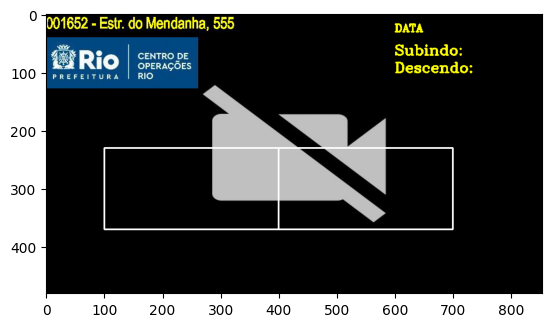

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

##Configurando os Parametros
max_frames = 180

area_1 = [(400, 230), (400, 370), (700, 370), (700, 230)]
area_2 = [(100, 230), (100, 370), (400, 370), (400, 230)]
#chamando video
cap = cv2.VideoCapture('http://187.111.99.18:9004/?CODE=1652')
ret_1, frame_1 = cap.read()
cv2.putText(frame_1, 'DATA',(600,30),cv2.FONT_HERSHEY_COMPLEX,0.6,(0,255,255),2)
cv2.putText(frame_1, 'Subindo: ', (600, 70), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0,255,255), 2)
cv2.putText(frame_1, 'Descendo: ', (600, 100), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0,255,255), 2)
cv2.polylines(frame_1, [np.array(area_1, np.int32)], True, (255, 255, 255), 2)
cv2.polylines(frame_1, [np.array(area_2, np.int32)], True, (255, 255, 255), 2)
visualize_frame(frame_1)


In [ ]:
# Verifique se o vídeo foi aberto corretamente
#roda o modelo
if not cap.isOpened():
    print("Erro ao abrir o vídeo.")
    exit()

# Obtenha as informações de shape e FPS do vídeo
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#fps = cap.get(cv2.CAP_PROP_FPS)
fps = 3

# Obtenha o fuso horário do Brasil
timezone = pytz.timezone('America/Sao_Paulo')

#configurando a saída de video
output_file = 'output.mp4'
execution_file = 'execution.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))
execution_out = cv2.VideoWriter(execution_file, fourcc, fps, (frame_width, frame_height))

cnt = 0
tracker = Tracker()
area_1 = [(400, 230), (400, 370), (700, 370), (700, 230)]
area_2 = [(100, 230), (100, 370), (400, 370), (400, 230)]
area_c_1 = []
area_c_2 = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (frame_width, frame_height))

    data_hora_formatada = datetime.now(timezone).strftime("%d/%m/%Y - %H:%M:%S")

    results = model.predict(frame, device=0)
    a = results[0].boxes.boxes.cpu()
    px = pd.DataFrame(a).astype("float")
    bbox_list = []

    #recebendo os valores das variáveis da de detecçcao
    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]

        if 'car' in c:
            bbox_list.append([x1, y1, x2, y2])

    bbox_id = tracker.update(bbox_list)

    for bbox in bbox_id:
        x1, y1, x2, y2, obj_id = bbox
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
        #Testando se o centroide está contido no poligono
        results_1 = cv2.pointPolygonTest(np.array(area_1, np.int32), (cx, cy), False)
        results_2 = cv2.pointPolygonTest(np.array(area_2, np.int32), (cx, cy), False)

        if results_1 >= 0: #se o resultado é acima de 0, ou seja, foi detectado
            #print (o circulo, o retangulo e a ID)
            cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(frame, str(obj_id), (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 0, 0), 1)
            if area_c_1.count(id)==0:
              area_c_1.append(obj_id)

        if results_2 >= 0: #se o resultado é acima de 0, ou seja, foi detectado
            #print (o circulo, o retangulo e a ID)
            cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(frame, str(obj_id), (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 0, 0), 1)
            if area_c_2.count(id)==0:
              area_c_2.append(obj_id)

    #Anotando info no video
    cv2.polylines(frame, [np.array(area_1, np.int32)], True, (255, 255, 255), 3) #poligono azil
    cv2.polylines(frame, [np.array(area_2, np.int32)], True, (255, 255, 255), 3) #poligono amarelo

    count_1 = len(area_c_1)
    count_2 = len(area_c_2)
    cv2.putText(frame,str(data_hora_formatada),(600,30),cv2.FONT_HERSHEY_COMPLEX,0.6,(0,255,255),2)
    cv2.putText(frame, 'Subindo: '+str(count_1), (600, 70), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0,255,255), 2)
    cv2.putText(frame, 'Descendo: '+str(count_2), (600, 90), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0,255,255), 2)

    out.write(frame)
    execution_out.write(frame)

    cnt += 1


    if cnt >= max_frames:
        break

cap.release()
out.release()
execution_out.release()
cv2.destroyAllWindows()


Ultralytics YOLOv8.0.124 🚀 Python-3.10.12 torch-2.0.1+cu118 


ValueError: ignored

In [ ]:
#ASSISTINDO O VIDEO NO COLAB

#transformando num formato para assistir no colab
import os
video_salvo = '/content/output.mp4'
video_final = '/content/execution.mp4'
os.system(f"ffmpeg -i {video_salvo} -vcodec libx264 {video_final}")


In [ ]:
#funcao para exibir o video
#código em HTML para exibir no colab
def exibir_video(video_caminho):
  from IPython.display import HTML
  from base64 import b64encode
  mp4 = open(video_caminho, 'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=500 controls>
    <source src="%s" type="video/mp4"
  </video>
  """ % data_url)

In [ ]:
exibir_video(video_final)